In [1]:
import igraph as ig
import math
import random as rd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange, date2num
import numpy as np
import random
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 18,
        }
params = {'legend.fontsize': 16,
          'legend.handlelength': 2.}
plt.rcParams.update(params)

import seaborn as sns
import itertools

In [2]:
import pandas as pd

df = pd.read_excel ('Book2.xlsx') #place "r" before the path string to address special character, such as '\'. Don't forget to put the file name at the end of the path + '.xlsx'
# print (df)

In [3]:
def double_smoothlog(time, bound1 , bound2, rate1 , rate2 , midpoint1 , midpoint2):
    result = []
    mini = 0
    maxi = time
    for x in range(time):
        if (midpoint1 > maxi | midpoint2 > maxi | midpoint1 < mini | midpoint2 < mini | midpoint1 > midpoint2):
            stop('midpoints not in range!')
        t1 = 1 / (1 + math.exp(-rate1*(x - midpoint1)))
        t2 = 1 / (1 + math.exp( rate2*(x - midpoint2)))
        out = bound1 + (bound2-bound1) * ((t1 + t2) - 1)
        result.append(out)
    return(result)

In [4]:
def simfxn(Time,popul):
    bound1 = 0.025
    bound2 = 0.001
    rate1 = 0.09
    rate2 = 0.04
    midpoint1 = 50
    midpoint2 = 126
    beta = double_smoothlog(Time, bound1 , bound2, rate1 , rate2 , midpoint1 , midpoint2)
    color_dict = {"S": "blue", "I": "red", "R": "green", "V":"orange"}
    g=ig.Graph.Erdos_Renyi(popul, m=5*popul)
    pop = g.vcount()
    g.vs["state"] = "S"
    g.vs["duration"] = 0
    #randomly select % of the population to be vaccinated
    perc_vac = int(0*pop)
    vac_eff = 0  # vaccine efficacy
    init_vac_grp = random.sample(list(range(pop)), perc_vac)
    g.vs[init_vac_grp]["state"] = "V"
    #randomly select an infected node to start epidemic
    i = rd.randint(0, pop-1)
#     g.vs[i]["state"] = "E"
    if g.vs[i]["state"] != 'V':   # if initial node is not vaccinated, then set it as exposed
        g.vs[i]["state"] = "E"
    
    nb_S = [pop-perc_vac]
    nb_E = [1]
    nb_I = [0]
    nb_R = [0]
    nb_V = [len(init_vac_grp)]
    exposed_vac = []
    Time = Time 
    count = 0 
    for time in range(Time): #no. of days     
        for n in g.vs.select(state_eq = "E"): #iterates through each node in the network
            g.vs[n.index]["duration"] += 1 
            if g.vs[n.index]["duration"] in range(7,17):  #(7,21)
                g.vs[n.index]["state"] = 'I'
                count = count + 1
#             else:
            for nb in g.neighbors(n): #iterates through neighbours of that node
                if g.vs[nb]["state"] == "S": #if node is infected...
#                     s = rd.random() #random state
                    s=np.random.binomial(1, beta[time],1)
                    if s == 1:
                        g.vs[nb]["state"] = "E" 
                if g.vs[nb]["state"] == "V": #if node is vaccinated...
#                     u = rd.random() #random state
                    u=np.random.binomial(1, (1-vac_eff)*beta[time],1)
                    if u == 1:
                        g.vs[nb]["state"] = "E" 
                        exposed_vac.append(nb)
                          
        for m in g.vs.select(state_eq = "I"): #iterates through each node in the network
            g.vs[m.index]["duration"] += 1 #from day 0 to infect_len this node continues to infect                                
            for nbm in g.neighbors(m): #iterates through neighbours of that node
                if g.vs[nbm]["state"] == "S": #if node is infected...
#                     j = rd.random() #random state
                    j=np.random.binomial(1, beta[time],1)
                    if j == 1:
                        g.vs[nbm]["state"] = "E"
            if g.vs[m.index]["duration"] in range(17,Time):
                g.vs[m.index]["state"] = 'R'
                
        nb_S.append(len(g.vs.select(state_eq = "S"))) #no. of susceptibles in population
        nb_E.append(len(g.vs.select(state_eq = "E"))) #no. of recovereds in population
        nb_I.append(len(g.vs.select(state_eq = "I"))) #no. of infecteds in population
        nb_R.append(len(g.vs.select(state_eq = "R"))) #no. of recovereds in population
        nb_V.append(len(g.vs.select(state_eq = "V"))) #no. of recovereds in population

    return(nb_S,nb_E,nb_I,nb_R,nb_V,count)



In [5]:
Time = 359
popul = 1000000
rep = 50
simout=simfxn(Time,popul)

In [6]:
datavector = []
for i in range(rep):          #repeat simulation 10 times
    simu = simfxn(Time,popul)
    datavector.append(simu)

KeyboardInterrupt: 

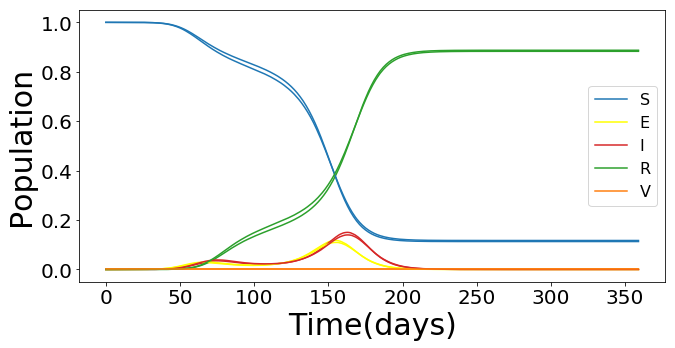

In [7]:
plt.figure(figsize=(10.5, 5))

plt.plot([x/popul for x in simout[0]], label='S',color = '#1f77b4')
plt.plot([x/popul for x in simout[1]], label='E',color = 'yellow')
plt.plot([x/popul for x in simout[2]], label='I',color = '#d62728')
plt.plot([x/popul for x in simout[3]], label='R',color = '#2ca02c')
plt.plot([x/popul for x in simout[4]], label='V',color = '#ff7f0e')
plt.legend(loc='right')

s_final = []
e_final = []
i_final = []
r_final = []

i_each = []

sList = []
eList = []
iList = []
rList = []

i_max = []

perc_inf = []
for n in datavector:
    sList = [x / popul for x in n[0]]
    eList = [x / popul for x in n[1]]
    iList = [x / popul for x in n[2]]
    rList = [x / popul for x in n[3]]
    vList = [x / popul for x in n[4]]
    num_inf = [n[5] / popul ]

 
    plt.plot(sList,color = '#1f77b4')
    plt.plot(eList,color = 'yellow')
    plt.plot(iList,color = '#d62728')
    plt.plot(rList,color = '#2ca02c')
    plt.plot(vList,color = '#ff7f0e')
    
    s_final.append(n[0][-1])
    e_final.append(n[1][-1])
    i_final.append(n[2][-1])
    r_final.append(n[3][-1])
#     v_final.append(n[4][-1])
    
    i_each.append(iList)
    i_max.append(max(iList))
    
    perc_inf.append(num_inf)
    
# plt.axvspan(50, 126, color='gray', alpha=0.5, lw=0)
# plt.legend(loc='right')
plt.tick_params(axis = 'both', which = 'major', labelsize = 20)
plt.ylabel('Population', fontsize=30) 
plt.xlabel('Time(days)', fontsize=30)
x=list(range(Time))
plt.xticks(np.arange(min(x), max(x)+20, 50.0))
plt.show()

# plt.savefig('%_efficacy.pdf', bbox_inches='tight')

In [11]:
flat_list = [item for sublist in i_each for item in sublist]

flat_list = []
for sublist in i_each:
    for item in sublist:
        flat_list.append(item)

In [12]:
datafr = pd.DataFrame(flat_list)

In [18]:
# dt = 390
reps =1

lst = range(0,12)
itl = list(itertools.chain.from_iterable(itertools.repeat(x, 30) for x in lst))

# datafr = datafr.assign(day=list(range(Time))*reps)
datafr = datafr.assign(month=itl*reps)

In [19]:
datafr.columns=["inf","months"]

In [20]:
df = datafr
med = datafr.groupby(['months'])['inf'].mean().reset_index()
mean_col = datafr.groupby(['months'])['inf'].median() # don't reset the index!
datafr = datafr.set_index(['months']) # make the same index here
datafr['mean_col'] = mean_col
datafr = datafr.reset_index() # to take the hierarchical index off again
# datafr

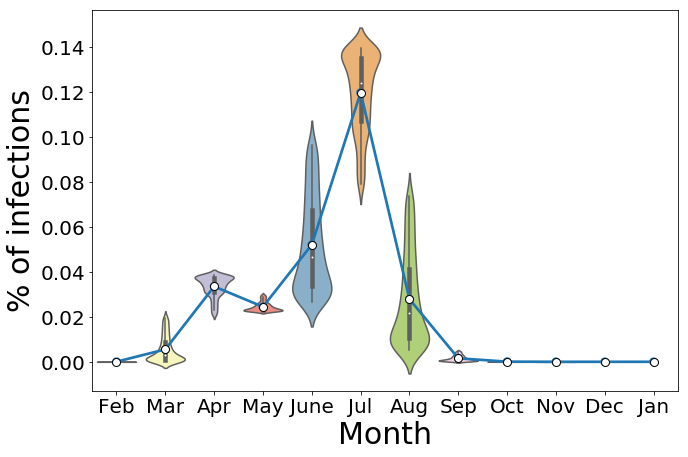

In [21]:
plt.figure(figsize=(10.5, 7))
qq = sns.violinplot(x="months", y="inf", data=datafr,palette="Set3",scale='count', bw=0.25)
# sns.stripplot(x="months", y="inf", data=datafr, jitter=True)

sns.swarmplot(x="months", y="inf", data=med,
              color='white', edgecolor='black', linewidth=1, size=8)

sns.pointplot(x="months", y="inf", data=med)


qq.set_xticklabels(['Feb','Mar','Apr','May','June','Jul', 'Aug','Sep','Oct','Nov','Dec', 'Jan'])
qq.set_ylabel("% of infections",fontsize=30)
qq.set_xlabel("Month",fontsize=30)
# sns.despine(left=True)
plt.tick_params(axis = 'both', which = 'major', labelsize = 20)

# plt.show()

plt.savefig('violin_novac.pdf', bbox_inches='tight')